analysis coming from [here](https://stmorse.github.io/journal/spotify-api.html)

In [2]:
import spotify
import requests
import pandas as pd
import numpy as np
import sklearn

In [5]:
CLIENT_ID = "fcadf02bcaa84f0cb14aa2121238ffe3"
CLIENT_SECRET = "1b0370a028b34a96b34ce74fbfa634bf"

In [6]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [7]:
# set header now so we can use it later to access data
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

In [8]:
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Track ID from the URI
track_id = '6y0igZArWVi6Iz0rj35c1Y'

# actual GET request with proper header
r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)

In [9]:
r = r.json()

In [10]:
r

{'danceability': 0.54,
 'energy': 0.59,
 'key': 0,
 'loudness': -4.359,
 'mode': 1,
 'speechiness': 0.0528,
 'acousticness': 0.446,
 'instrumentalness': 0,
 'liveness': 0.14,
 'valence': 0.267,
 'tempo': 119.878,
 'type': 'audio_features',
 'id': '6y0igZArWVi6Iz0rj35c1Y',
 'uri': 'spotify:track:6y0igZArWVi6Iz0rj35c1Y',
 'track_href': 'https://api.spotify.com/v1/tracks/6y0igZArWVi6Iz0rj35c1Y',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6y0igZArWVi6Iz0rj35c1Y',
 'duration_ms': 234910,
 'time_signature': 4}

Pull all Led Zeppelin data from Spotify

In [11]:
artist_id = '36QJpDe2go2KgaRleHCDTp' #LZ artist ID

# pull all artists albums
r = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50})
d = r.json()

In [12]:
for album in d['items']:
    print(album['name'], ' --- ', album['release_date'])

The Complete BBC Sessions (Remastered)  ---  2016-09-16
Physical Graffiti (Deluxe Edition)  ---  2015-02-20
Celebration Day  ---  2012-11-19
Mothership (Remastered)  ---  2007
How the West Was Won (Remaster)  ---  2003-05-27
The Lost Sessions  ---  1997
Coda (Deluxe Edition)  ---  1982-11-19
Coda (Remaster)  ---  1982-11-19
In Through the out Door (Deluxe Edition)  ---  1979-08-15
In Through the out Door (Remaster)  ---  1979-08-15
The Song Remains the Same (Remaster)  ---  1976-10-22
Presence (Deluxe Edition)  ---  1976-03-31
Presence (Remaster)  ---  1976-03-31
Physical Graffiti (Remaster)  ---  1975-02-24
Physical Graffiti (1994 Remaster)  ---  1975-02-24
Physical Graffiti (Deluxe Edition)  ---  1975-02-24
Houses of the Holy (Deluxe Edition)  ---  1973-03-28
Houses of the Holy (Remaster)  ---  1973-03-28
Led Zeppelin IV (Deluxe Edition)  ---  1971-11-08
Led Zeppelin IV (Remaster)  ---  1971-11-08
Led Zeppelin III (Deluxe Edition)  ---  1970-10-05
Led Zeppelin III (Deluxe Edition)  -

In [13]:
data = []   # will hold all track info
albums = [] # to keep track of duplicates

# loop over albums and get all tracks
for album in d['items']:
    album_name = album['name']

    # here's a hacky way to skip over albums we've already grabbed
    trim_name = album_name.split('(')[0].strip()
    if trim_name.upper() in albums or int(album['release_date'][:4]) > 1983:
        continue
    albums.append(trim_name.upper()) # use upper() to standardize
    
    # this takes a few seconds so let's keep track of progress    
    print(album_name)
    
    # pull all tracks from this album
    r = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
    tracks = r.json()['items']
    
    for track in tracks:
        # get audio features (key, liveness, danceability, ...)
        f = requests.get(BASE_URL + 'audio-features/' + track['id'], 
            headers=headers)
        f = f.json()
        
        # combine with album info
        f.update({
            'track_name': track['name'],
            'album_name': album_name,
            'short_album_name': trim_name,
            'release_date': album['release_date'],
            'album_id': album['id']
        })
        
        data.append(f)

Coda (Deluxe Edition)
In Through the out Door (Deluxe Edition)
The Song Remains the Same (Remaster)
Presence (Deluxe Edition)
Physical Graffiti (Remaster)
Houses of the Holy (Deluxe Edition)
Led Zeppelin IV (Deluxe Edition)
Led Zeppelin III (Deluxe Edition)
Led Zeppelin II (Deluxe Edition)
Led Zeppelin (Deluxe Edition)


In [14]:
# convert list of dicts into a dataframe
df = pd.DataFrame(data)

In [15]:
# convert release_date to an actual date, and sort by it
df['release_date'] = pd.to_datetime(df['release_date'])
df = df.sort_values(by='release_date')

# Zeppelin-specific: get rid of live album, remixes, vocal tracks, ...
df = df.query('short_album_name != "The Song Remains The Same"')
df = df[~df['track_name'].str.contains('Live|Mix|Track')]

In [16]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,track_name,album_name,short_album_name,release_date,album_id
143,0.445,0.703,9,-9.783,1,0.0859,0.0828,0.000003,0.0782,0.633,...,spotify:track:6sMGNw1E4q79DoAFGDCYuD,https://api.spotify.com/v1/tracks/6sMGNw1E4q79...,https://api.spotify.com/v1/audio-analysis/6sMG...,166107,4,Good Times Bad Times - Remaster,Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,22BzOOZKYZ2jYYKLpOlnET
144,0.411,0.466,4,-11.537,0,0.0332,0.3750,0.000085,0.1420,0.158,...,spotify:track:1Y6xEUUKAVWO060yJRCces,https://api.spotify.com/v1/tracks/1Y6xEUUKAVWO...,https://api.spotify.com/v1/audio-analysis/1Y6x...,402761,4,Babe I'm Gonna Leave You - Remaster,Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,22BzOOZKYZ2jYYKLpOlnET
145,0.366,0.560,11,-10.361,0,0.0633,0.6470,0.007030,0.1800,0.361,...,spotify:track:2Y1HhOfvtzms7urVKFY67n,https://api.spotify.com/v1/tracks/2Y1HhOfvtzms...,https://api.spotify.com/v1/audio-analysis/2Y1H...,388467,3,You Shook Me - Remaster,Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,22BzOOZKYZ2jYYKLpOlnET
146,0.240,0.546,2,-10.026,1,0.0548,0.0898,0.006480,0.0898,0.429,...,spotify:track:2WbfcArcwBvsbnikIQdBN9,https://api.spotify.com/v1/tracks/2WbfcArcwBvs...,https://api.spotify.com/v1/audio-analysis/2Wbf...,388667,4,Dazed and Confused - Remaster,Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,22BzOOZKYZ2jYYKLpOlnET
147,0.328,0.575,7,-10.437,1,0.0439,0.3510,0.000556,0.6880,0.249,...,spotify:track:0by20SqfRktdZ6hdd0byjt,https://api.spotify.com/v1/tracks/0by20SqfRktd...,https://api.spotify.com/v1/audio-analysis/0by2...,274694,4,Your Time Is Gonna Come - Remaster,Led Zeppelin (Deluxe Edition),Led Zeppelin,1969-01-12,22BzOOZKYZ2jYYKLpOlnET


## time for data visualization

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

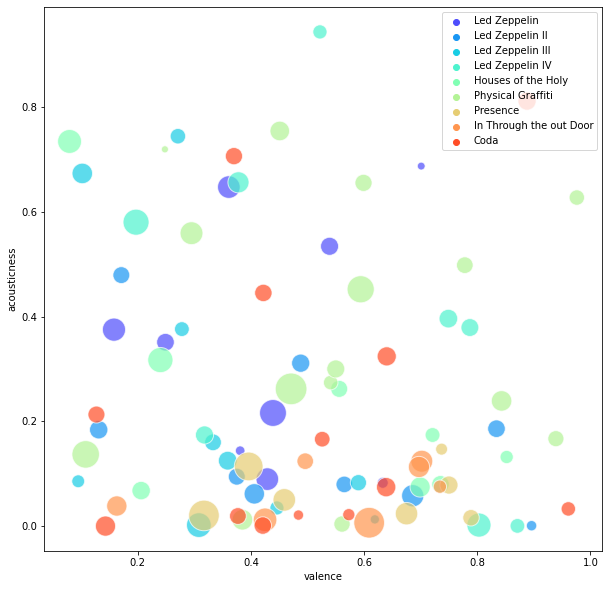

In [35]:
plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=df, x='valence', y='acousticness', 
                     hue='short_album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', title=None)

## Dimensionality reduction

This is great for working with comparing two dimensions across all of Led Zeppelin's tracks, but for doing any more advanced kind of analysis, then we'd like to do dimensionality reduction. PCA is a good place to start, but it's limited in that the lower-dimensional surface you project your data onto is strictly linear (and most data is non-linear in higher dimensions). So let's try to learn a non-linear manifold using t-SNE (thanks Josh Tenenbaum).

In [19]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# extract relevant columns to numpy array
X = (df
 .filter(['acousticness', 'danceability', 'duration_ms', 'energy',
          'instrumentalness', 'liveness', 'loudness', 'tempo', 'valence'])
)

# algo will do better if data is standardized (zero mean, unit variance)
Xs = StandardScaler().fit_transform(X)

In [42]:
# construct 2-d embedding
tsne = TSNE(n_components=2, perplexity=5, 
    early_exaggeration=2, random_state=3).fit_transform(Xs)

# convert to dataframe for plotting purposes
tsne = pd.DataFrame(tsne)
tsne['short_album_name'] = df['short_album_name']
tsne['duration_ms'] = df['duration_ms']

plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=tsne, x=0, y=1, 
                     hue='short_album_name', palette='rainbow', 
                     size='duration_ms', sizes=(50,1000), 
                     alpha=0.7)

# display legend without `size` attribute
h,labs = ax.get_legend_handles_labels()
ax.legend(h[1:10], labs[1:10], loc='best', ncol=2)

plt.show()

TypeError: object of type 'int' has no len()

<Figure size 720x720 with 0 Axes>

AttributeError: 'DataFrame' object has no attribute 'len'